<a href="https://colab.research.google.com/github/mccoymb/AAE-590-DSMM/blob/main/AAE590DSMM_HW5_P2_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
time_values = np.array([25000, 28000, 31000, 35000, 37500, 40000, 45000, 50000, 75000, 108000,
                        180000, 220000, 250000, 270000, 300000, 360000, 430000, 540000, 900000, 1080000])

In [3]:
data = np.load('/content/drive/My Drive/590TrainingData/train.npz')
print("Keys in npz file:", data.files)
input_raw_data = data['input_raw_data']  # Shape: (200000, 1, 64, 64)


Keys in npz file: ['clips', 'dims', 'input_raw_data']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN Pearson R = 0.5474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


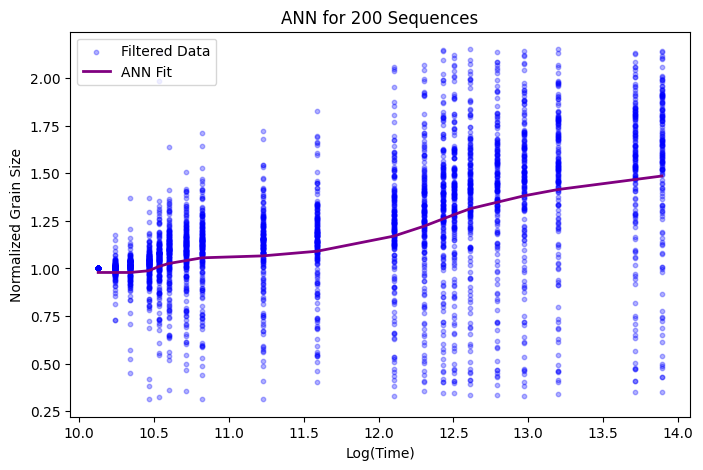

In [4]:
num_sequences = 200
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Normalize X (log time) for neural network stability
X_mean = X_filtered.mean()
X_std = X_filtered.std()
X_norm = (X_filtered - X_mean) / X_std

# Reshape inputs for Keras
X_input = X_norm.reshape(-1, 1)
Y_output = Y_filtered.reshape(-1, 1)
# Define ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_input, Y_output, epochs=500, batch_size=32, verbose=0)

# Predict using the trained model
predictions = model.predict(X_input).flatten()

# Compute Pearson R-value
r_value, _ = pearsonr(Y_filtered, predictions)

# Report R-value
print(f"ANN Pearson R = {r_value:.4f}")
# Predict on original log(time) for smooth curve
log_time_line = np.log(time_values)
log_time_line_norm = (log_time_line - X_mean) / X_std
y_ann = model.predict(log_time_line_norm.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(log_time_line, y_ann, label="ANN Fit", color="purple", linewidth=2)
plt.title("ANN for 200 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ANN Pearson R = 0.5378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


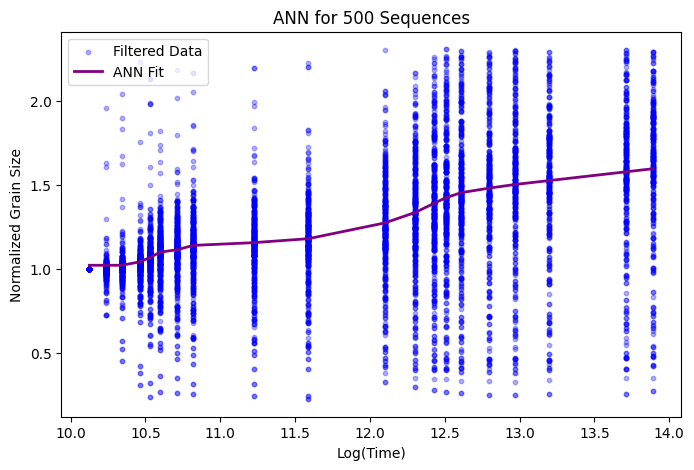

In [5]:
num_sequences = 500
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Normalize X (log time) for neural network stability
X_mean = X_filtered.mean()
X_std = X_filtered.std()
X_norm = (X_filtered - X_mean) / X_std

# Reshape inputs for Keras
X_input = X_norm.reshape(-1, 1)
Y_output = Y_filtered.reshape(-1, 1)
# Define ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_input, Y_output, epochs=500, batch_size=32, verbose=0)

# Predict using the trained model
predictions = model.predict(X_input).flatten()

# Compute Pearson R-value
r_value, _ = pearsonr(Y_filtered, predictions)

# Report R-value
print(f"ANN Pearson R = {r_value:.4f}")
# Predict on original log(time) for smooth curve
log_time_line = np.log(time_values)
log_time_line_norm = (log_time_line - X_mean) / X_std
y_ann = model.predict(log_time_line_norm.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(log_time_line, y_ann, label="ANN Fit", color="purple", linewidth=2)
plt.title("ANN for 500 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ANN Pearson R = 0.6397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


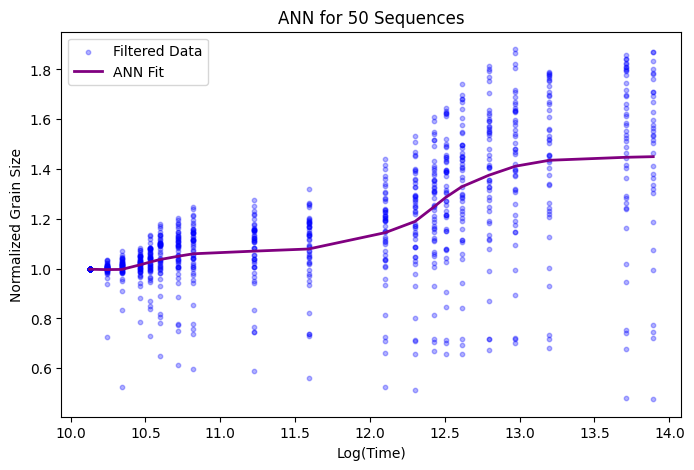

In [6]:
num_sequences = 50
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Normalize X (log time) for neural network stability
X_mean = X_filtered.mean()
X_std = X_filtered.std()
X_norm = (X_filtered - X_mean) / X_std

# Reshape inputs for Keras
X_input = X_norm.reshape(-1, 1)
Y_output = Y_filtered.reshape(-1, 1)
# Define ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_input, Y_output, epochs=500, batch_size=32, verbose=0)

# Predict using the trained model
predictions = model.predict(X_input).flatten()

# Compute Pearson R-value
r_value, _ = pearsonr(Y_filtered, predictions)

# Report R-value
print(f"ANN Pearson R = {r_value:.4f}")
# Predict on original log(time) for smooth curve
log_time_line = np.log(time_values)
log_time_line_norm = (log_time_line - X_mean) / X_std
y_ann = model.predict(log_time_line_norm.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(log_time_line, y_ann, label="ANN Fit", color="purple", linewidth=2)
plt.title("ANN for 50 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()



117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN Pearson R = 0.5470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Pearson R = 0.5319


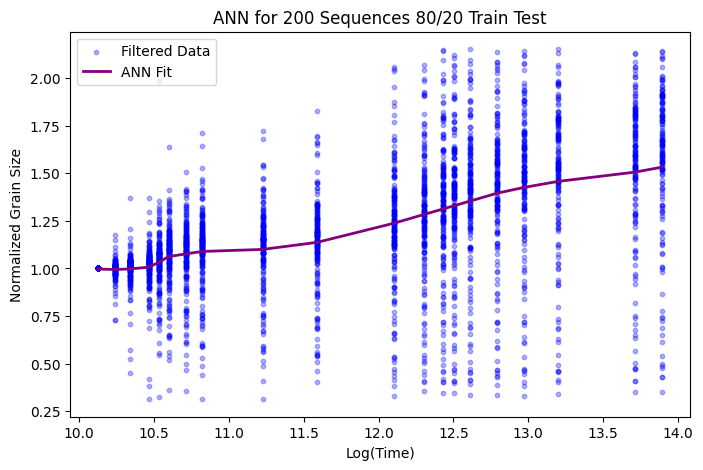

In [10]:
num_sequences = 200
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Normalize X (log time) for neural network stability
X_mean = X_filtered.mean()
X_std = X_filtered.std()
X_norm = (X_filtered - X_mean) / X_std

# Reshape inputs for Keras
X_input = X_norm.reshape(-1, 1)
Y_output = Y_filtered.reshape(-1, 1)
# Define ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
X_train, X_test, Y_train, Y_test = train_test_split(X_input, Y_output, test_size=0.2, random_state=42)
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=0)

# Predict using the trained model
predictions = model.predict(X_input).flatten()

# Compute Pearson R-value
r_value, _ = pearsonr(Y_filtered, predictions)

# Report R-value
print(f"ANN Pearson R = {r_value:.4f}")
# Predict on original log(time) for smooth curve
log_time_line = np.log(time_values)
log_time_line_norm = (log_time_line - X_mean) / X_std
y_ann = model.predict(log_time_line_norm.reshape(-1, 1)).flatten()
# Predict and evaluate on test set
Y_pred_test = model.predict(X_test).flatten()
test_r_value, _ = pearsonr(Y_test.flatten(), Y_pred_test)

print(f"Test Pearson R = {test_r_value:.4f}")
# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(log_time_line, y_ann, label="ANN Fit", color="purple", linewidth=2)
plt.title("ANN for 200 Sequences 80/20 Train Test")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN Pearson R = 0.5455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Pearson R = 0.5275


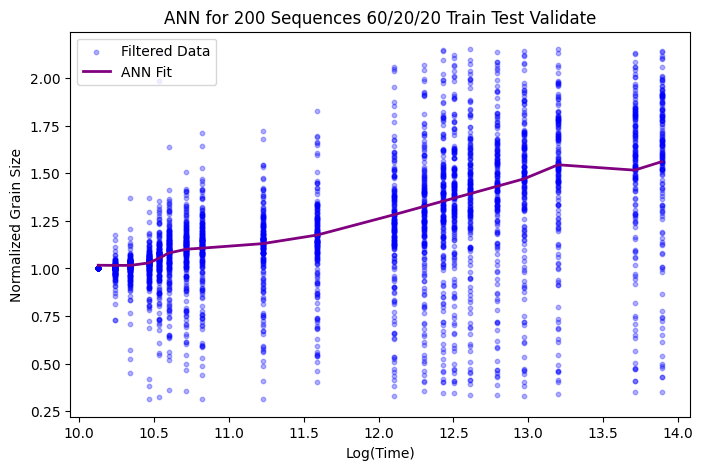

In [11]:
num_sequences = 200
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Normalize X (log time) for neural network stability
X_mean = X_filtered.mean()
X_std = X_filtered.std()
X_norm = (X_filtered - X_mean) / X_std

# Reshape inputs for Keras
X_input = X_norm.reshape(-1, 1)
Y_output = Y_filtered.reshape(-1, 1)
# Define ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# First split into 80% train_val and 20% test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_input, Y_output, test_size=0.2, random_state=42)

# Now split train_val into 75% train and 25% validation (i.e., 60/20 split overall)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_val, Y_val), verbose=0)


# Predict using the trained model
predictions = model.predict(X_input).flatten()

# Compute Pearson R-value
r_value, _ = pearsonr(Y_filtered, predictions)

# Report R-value
print(f"ANN Pearson R = {r_value:.4f}")
# Predict on original log(time) for smooth curve
log_time_line = np.log(time_values)
log_time_line_norm = (log_time_line - X_mean) / X_std
y_ann = model.predict(log_time_line_norm.reshape(-1, 1)).flatten()
# Predict and evaluate on test set
Y_pred_test = model.predict(X_test).flatten()
test_r_value, _ = pearsonr(Y_test.flatten(), Y_pred_test)

print(f"Test Pearson R = {test_r_value:.4f}")
# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(log_time_line, y_ann, label="ANN Fit", color="purple", linewidth=2)
plt.title("ANN for 200 Sequences 60/20/20 Train Test Validate")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()
